<a href="https://colab.research.google.com/github/opardo/SoccerLearning/blob/master/RNNApproach/Exploration_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN & RNN Approach

## Caveat: This notebook is intended to be run using Colab, and having the data in a Drive folder to which the user has access.

## Several sections of this file were inspired by this [notebook](https://github.com/random-forests/adl-fall-19/blob/master/a4.ipynb) written by Prof. Joshua Gordon.

## Import libraries

In [1]:
try:
    %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
    pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import os
import csv
import random
import time

In [0]:
import pandas as pd
import numpy as np

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
from google.colab import drive

In [0]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential

## Set paths

In [0]:
colab_root = "/content/" 
drive_root = "drive/My Drive/" + "SoccerLearning/" # CHANGE THIS TO THE DRIVE FOLDER WHERE YOU STORE THE DATA

In [10]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
labels_path = os.path.join(drive_root, "labels.csv")
images_path = os.path.join(drive_root, "clasico_frames.zip")

## Load data

In [0]:
!cp "$labels_path" .

In [0]:
!cp "$images_path" .

In [0]:
images_folder = os.path.join(colab_root, 'clasico_frames/')

In [0]:
!unzip -q clasico_frames.zip -d .

In [16]:
!ls

clasico_frames	clasico_frames.zip  drive  labels.csv  sample_data


## Data Wrangling

In [17]:
labels_df = pd.read_csv('labels.csv')
labels_df

frame  label
0         0      0
1        10      0
2        20      0
3        30      0
4        40      0
...     ...    ...
8578  85780      3
8579  85790      3
8580  85800      3
8581  85810      3
8582  85820      3

[8583 rows x 2 columns]

In [18]:
def frame_num_to_image_path(frame):
    return(os.path.join(colab_root, "clasico_frames/frame%s.jpg" % frame))

labels_df['img_path'] = list(map(frame_num_to_image_path, labels_df['frame']))
labels_df

frame  label                                img_path
0         0      0      /content/clasico_frames/frame0.jpg
1        10      0     /content/clasico_frames/frame10.jpg
2        20      0     /content/clasico_frames/frame20.jpg
3        30      0     /content/clasico_frames/frame30.jpg
4        40      0     /content/clasico_frames/frame40.jpg
...     ...    ...                                     ...
8578  85780      3  /content/clasico_frames/frame85780.jpg
8579  85790      3  /content/clasico_frames/frame85790.jpg
8580  85800      3  /content/clasico_frames/frame85800.jpg
8581  85810      3  /content/clasico_frames/frame85810.jpg
8582  85820      3  /content/clasico_frames/frame85820.jpg

[8583 rows x 3 columns]

In [0]:
def get_human_label(label):
    if label == 0:
        return('death ball')
    elif label == 1:
        return('real madrid')
    elif label == 2:
        return('barcelona')
    elif label == 3:
        return('replay')

Tag: death ball


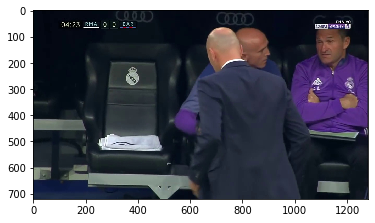

Tag: real madrid


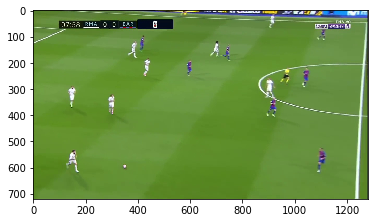

Tag: barcelona


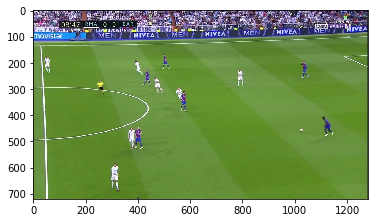

Tag: barcelona


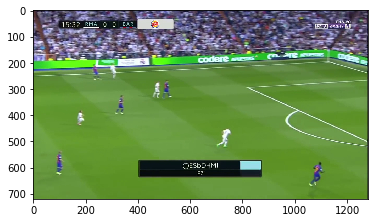

Tag: real madrid


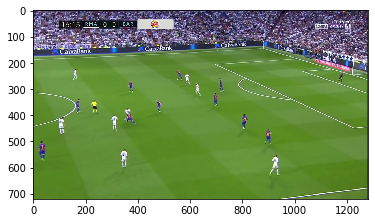

Tag: replay


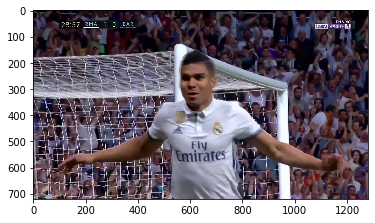

In [20]:
random.seed(1234)
for index, row in labels_df.iterrows():
    frame = row['frame']
    label = row['label']
    img_path = row['img_path']

    # Verify the image is in the folder
    assert os.path.exists(img_path)   

  # Shows some images
    if random.random() < 0.001:
        image_ = mpimg.imread(img_path)
        print('Tag: %s' % get_human_label(label))
        plt.gca().clear()
        plt.imshow(image_)
        plt.show()      

## Split train, validation and test 

We are going to train using only the first 15 minutes, and see if we can predict the next 30.

In [0]:
FRAME_THRESHOLD = 2725 #First 15 minutes
#FRAME_MEMORY = 9 # how many of the previous frames to remember
FRAME_MEMORY = 0
train_val = labels_df[FRAME_MEMORY:FRAME_THRESHOLD]
test = labels_df[FRAME_THRESHOLD:]
train, val = train_test_split(train_val, test_size=0.2, shuffle=False)

In [22]:
train_val

frame  label                                img_path
0         0      0      /content/clasico_frames/frame0.jpg
1        10      0     /content/clasico_frames/frame10.jpg
2        20      0     /content/clasico_frames/frame20.jpg
3        30      0     /content/clasico_frames/frame30.jpg
4        40      0     /content/clasico_frames/frame40.jpg
...     ...    ...                                     ...
2720  27200      1  /content/clasico_frames/frame27200.jpg
2721  27210      1  /content/clasico_frames/frame27210.jpg
2722  27220      1  /content/clasico_frames/frame27220.jpg
2723  27230      1  /content/clasico_frames/frame27230.jpg
2724  27240      1  /content/clasico_frames/frame27240.jpg

[2725 rows x 3 columns]

## Save activations from Inception V3 for all the images

In [23]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 2s 0us/step


In [0]:
# A method to load an image off disk, and extract activations using 
# the model above. 
def image_to_activations(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    activations = tf.keras.applications.inception_v3.preprocess_input(img)
    return activations, image_path

In [25]:
image_path_set = set(labels_df['img_path'])

print("Images to preprocess", len(image_path_set))
print("This make take a few minutes")

Images to preprocess 8583
This make take a few minutes


In [0]:
# This cell will extract activations for each image and save them to disk 
# in NumPy format. 

# Create a dataset to load each image off disk, and extract activations
activation_dataset = tf.data.Dataset.from_tensor_slices(list(image_path_set))
activation_dataset = activation_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# Save all activations to disk in NumPy format
for img_batch, path_batch in activation_dataset:
  batch_features = image_features_extract_model(img_batch)
  for bf, p in zip(batch_features, path_batch):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())  

## Convert data to an appropiate batch format to train the model

In [0]:
labels_train = list([1.0 * label for label in train['label']]) 
images_train = list(train['img_path']) 

labels_val = list([1.0 * label for label in val['label']]) 
images_val = list(val['img_path']) 

labels_test = list([1.0 * label for label in test['label']]) 
images_test = list(test['img_path']) 

In [0]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [0]:
def load_np(img_path, label):
    ## Example URL :
    ## "/content/clasico_frames/frame18920.jpg"
    img_number = int(img_path.decode('utf-8').split('/')[3][5:-4])
    #activations = list()
    #activations.append(np.load(img_path.decode('utf-8')+'.npy'))
    activations = np.load(img_path.decode('utf-8')+'.npy')
    # Last 9 frames
    #for frame in range(1, FRAME_MEMORY+1):
    #    old_img_number = img_number - 10 * frame
    #    img_path_old = img_path.decode('utf-8').replace(str(img_number), str(old_img_number))
    #    activations.append(np.load(img_path_old + '.npy'))
    #activations = np.array(activations)
    return activations, label, img_path

def create_dataset(images, labels, shuff = True):
    dataset = tf.data.Dataset.from_tensor_slices((images, 
                                                  labels))
    # Load the cached activations off disk
    dataset = dataset.map(lambda x, y: tf.numpy_function( 
        load_np, [x, y], [tf.float32, tf.float32, tf.string]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Shuffle and batch
    if shuff:
        dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    else:
        dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
train_ds = create_dataset(images_train, labels_train, shuff = False)
val_ds = create_dataset(images_val, labels_val, shuff = False)
test_ds = create_dataset(images_test, labels_test, shuff = False)

In [31]:
my_iterator = iter(train_ds)
activations_batch, labels_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
      labels_batch.shape, 
      paths_batch.shape)

#print(activations_batch, 
#      labels_batch, 
#      paths_batch)

(32, 8, 8, 2048) (32,) (32,)


In [0]:
#!ls -l '/content/clasico_frames' --human-readable

## Design the CNN + RNN

In [0]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, LSTM
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, GRU
from tensorflow.keras.models import Model, Sequential

image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(GlobalAveragePooling2D())
encoded_image = vision_model(image_input)

#embedding = Embedding(input_dim=10000, output_dim=256, input_length=2048)(encoded_image)
encoded_image = Reshape((1, 2048))(encoded_image)
gru_1 = GRU(32)(encoded_image)

# Add dense layers between the activations and the output
dense = Dense(64, activation='relu')(gru_1)
dense = Dense(64, activation='relu')(dense)

# Next, add a binary classifier on top
output = Dense(4, activation='softmax')(dense)

model = Model(inputs=image_input, outputs=output)

In [34]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8, 8, 2048)]      0         
_________________________________________________________________
sequential (Sequential)      (None, 2048)              0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 2048)           0         
_________________________________________________________________
gru (GRU)                    (None, 32)                199872    
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260 

In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

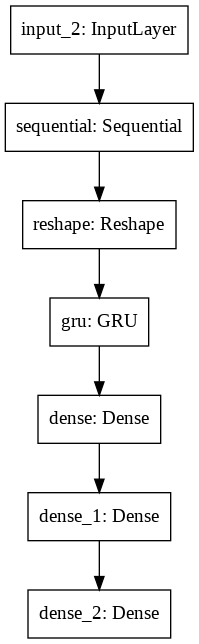

In [36]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

## Train on a single batch to verify everything is working

In [0]:
# Retrieve a batch of data from your train dataset
activations_batch, labels_batch, paths_batch = next(iter(train_ds))

In [38]:
'''activations_batch = tf.reshape(activations_batch, [1, 32, 8, 8, 2048])
activations_batch.shape'''

'activations_batch = tf.reshape(activations_batch, [1, 32, 8, 8, 2048])\nactivations_batch.shape'

In [0]:
for i in range(100):
  metrics = model.train_on_batch(activations_batch, labels_batch)

In [40]:
print('Loss: %f' % metrics[0])
print('Accuracy: %f' % metrics[1])

Loss: 0.000173
Accuracy: 1.000000


In [41]:
for prediction, label in zip(model.predict(x=activations_batch), labels_batch):
  print(prediction, label.numpy())

[9.9982738e-01 8.1672501e-05 2.9521205e-05 6.1404549e-05] 0.0
[9.9982762e-01 8.1515806e-05 2.9355628e-05 6.1413819e-05] 0.0
[9.9982870e-01 8.1073129e-05 2.9059176e-05 6.1220620e-05] 0.0
[9.9982941e-01 8.0713762e-05 2.9016026e-05 6.0891733e-05] 0.0
[9.9982941e-01 8.0745711e-05 2.9023857e-05 6.0887436e-05] 0.0
[9.9983060e-01 8.0134938e-05 2.8505439e-05 6.0787137e-05] 0.0
[9.9983001e-01 8.0356753e-05 2.8529139e-05 6.1051040e-05] 0.0
[9.9983060e-01 8.0052901e-05 2.8521185e-05 6.0731221e-05] 0.0
[9.998300e-01 8.034319e-05 2.841225e-05 6.116415e-05] 0.0
[9.9983072e-01 8.0028636e-05 2.8203640e-05 6.1030587e-05] 0.0
[9.9983048e-01 8.0125836e-05 2.8091454e-05 6.1248757e-05] 0.0
[9.9983072e-01 7.9963029e-05 2.8029966e-05 6.1235631e-05] 0.0
[9.9982846e-01 8.1032682e-05 2.8344548e-05 6.2080573e-05] 0.0
[9.9982750e-01 8.1532278e-05 2.8441784e-05 6.2553401e-05] 0.0
[9.9982965e-01 8.0472986e-05 2.7979673e-05 6.1917752e-05] 0.0
[9.9983168e-01 7.9487829e-05 2.7723361e-05 6.1077924e-05] 0.0
[9.9983144e-

## Manage checkpoints in case we want to fit the model for a long time

In [0]:
# if changed model remove checkpoints folder
!rm -r "/content/drive/My Drive/SoccerLearning/soccer_checkpoints"

In [43]:
checkpoint_dir = os.path.join(drive_root, "soccer_checkpoints/CNN")
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
    print("Checkpoints folder already exists")
else:
    print("Creating a checkpoints directory")
    os.makedirs(checkpoint_dir)

Checkpoints directory is drive/My Drive/SoccerLearning/soccer_checkpoints/CNN
Creating a checkpoints directory


In [44]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


## Fit the model

In [0]:
# Utilities to help us record metrics.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [0]:
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, label_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=activation_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions)

In [47]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 50 

# Training loop
for epoch in range(epochs):

    start = time.time()

    # Train for one epoch
    for activation_batch, label_batch, path_batch in train_ds:
        result = model.train_on_batch(x=activation_batch, y=label_batch)

        # Record metrics after each batch
        train_loss(result[0])
        train_accuracy(result[1])

    # Evaluate for a few steps
    evaluate(max_steps=100)

    # Print progress
    template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
    print(template.format(epoch,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          val_loss.result(),
                          val_accuracy.result() * 100,
                          time.time() - start))
    
    # Record history
    train_loss_history.append(train_loss.result())
    train_acc_history.append(train_accuracy.result() * 100)
    val_loss_history.append(val_loss.result())
    val_acc_history.append(val_accuracy.result() * 100)

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Save a checkpoint after each epoch
    print("Saving weights")
    model.save_weights(checkpoint_path.format(epoch=epoch))

Epoch 0, Loss: 1.93, Accuracy: 33.02, Val Loss 1.22, Val Accuracy 51.38, Time: 5.1 secs
Saving weights
Epoch 1, Loss: 1.30, Accuracy: 28.62, Val Loss 1.13, Val Accuracy 55.78, Time: 4.8 secs
Saving weights
Epoch 2, Loss: 1.21, Accuracy: 34.33, Val Loss 1.06, Val Accuracy 63.30, Time: 4.7 secs
Saving weights
Epoch 3, Loss: 1.17, Accuracy: 39.49, Val Loss 1.04, Val Accuracy 64.95, Time: 4.4 secs
Saving weights
Epoch 4, Loss: 1.13, Accuracy: 37.73, Val Loss 1.02, Val Accuracy 68.26, Time: 4.4 secs
Saving weights
Epoch 5, Loss: 1.11, Accuracy: 41.12, Val Loss 1.00, Val Accuracy 67.89, Time: 4.6 secs
Saving weights
Epoch 6, Loss: 1.10, Accuracy: 45.65, Val Loss 0.99, Val Accuracy 66.97, Time: 4.7 secs
Saving weights
Epoch 7, Loss: 1.05, Accuracy: 42.35, Val Loss 0.98, Val Accuracy 67.52, Time: 4.6 secs
Saving weights
Epoch 8, Loss: 1.00, Accuracy: 45.11, Val Loss 0.91, Val Accuracy 67.34, Time: 5.1 secs
Saving weights
Epoch 9, Loss: 0.97, Accuracy: 52.49, Val Loss 0.87, Val Accuracy 70.64, 

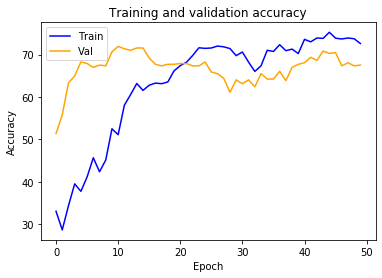

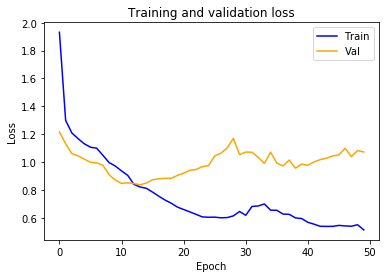

In [48]:
def plot(loss, acc, val_loss, val_acc):
  
  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

## Predict on the test dataset and save results

In [49]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
model.load_weights(latest)
print("loaded weights from", latest)

loaded weights from drive/My Drive/SoccerLearning/soccer_checkpoints/CNN/cp-00000049.ckpt


True label: replay
Predicted label: replay
Confidence of the prediction: 0.9908337


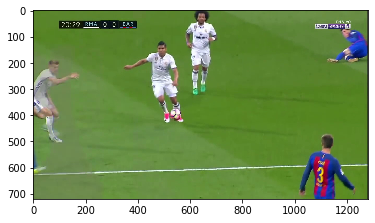

True label: barcelona
Predicted label: barcelona
Confidence of the prediction: 0.88438076


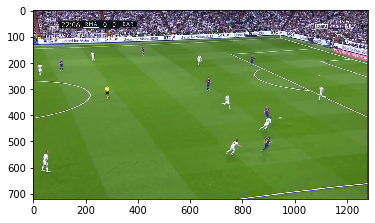

True label: real madrid
Predicted label: barcelona
Confidence of the prediction: 0.8842183


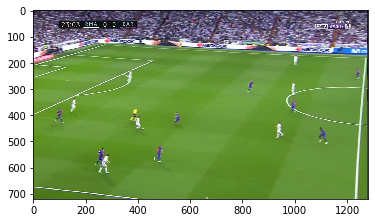

True label: death ball
Predicted label: death ball
Confidence of the prediction: 0.9959508


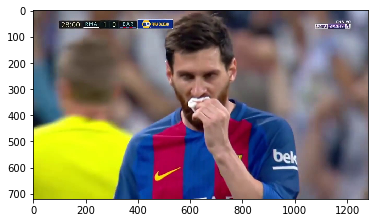

True label: barcelona
Predicted label: barcelona
Confidence of the prediction: 0.8756595


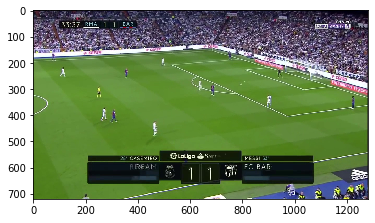

True label: real madrid
Predicted label: barcelona
Confidence of the prediction: 0.8012656


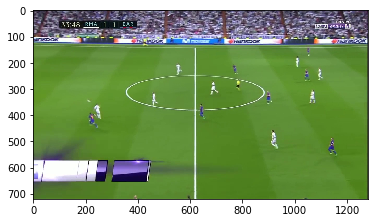

True label: real madrid
Predicted label: barcelona
Confidence of the prediction: 0.598995


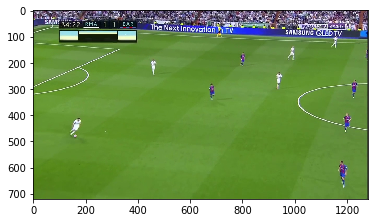

True label: replay
Predicted label: replay
Confidence of the prediction: 0.99884725


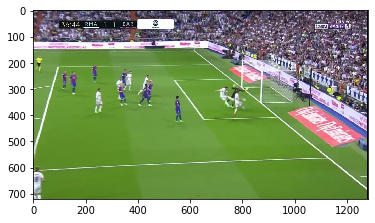

True label: death ball
Predicted label: real madrid
Confidence of the prediction: 0.72676593


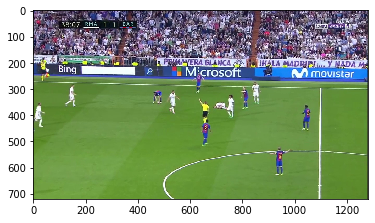

True label: barcelona
Predicted label: barcelona
Confidence of the prediction: 0.8775899


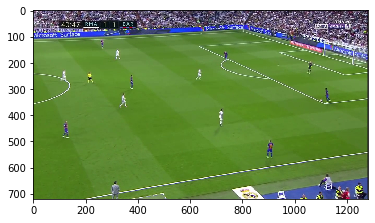

True label: death ball
Predicted label: barcelona
Confidence of the prediction: 0.6889052


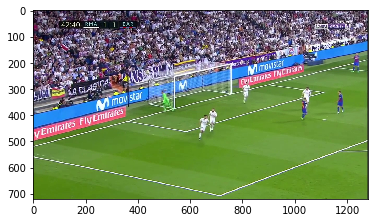

True label: real madrid
Predicted label: barcelona
Confidence of the prediction: 0.7496786


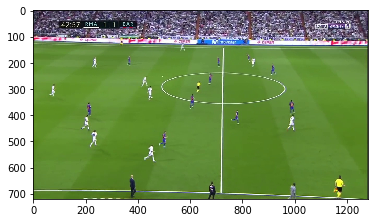

True label: barcelona
Predicted label: barcelona
Confidence of the prediction: 0.8822856


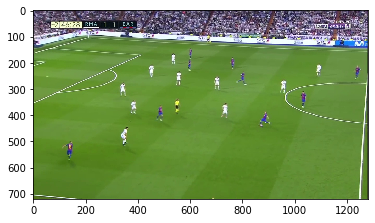

True label: replay
Predicted label: death ball
Confidence of the prediction: 0.9829379


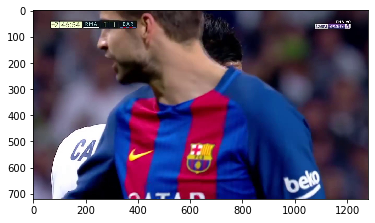

In [50]:
random.seed(2021)
acc_list = list()
predictions_list = list()
confidences_list = list()
paths_list = list()

for activation_batch, label_batch, path_batch in test_ds:
    score, acc = model.evaluate(activation_batch, label_batch, verbose=0)
    acc_list.append(acc)
    
    preds = model.predict(activation_batch)
    predictions_batch = list(np.argmax(preds, axis = 1))
    confidences_batch = list(np.max(preds, axis = 1))
    paths_batch = list(path_batch.numpy())
    paths_batch = [path.decode('utf-8') for path in paths_batch]
    labels_batch = list(label_batch.numpy())

    predictions_list = predictions_list + predictions_batch
    confidences_list = confidences_list + confidences_batch
    paths_list = paths_list + paths_batch

    for i in range(len(labels_batch)):
        if random.random() < 0.002:
            print('True label: %s' % get_human_label(labels_batch[i]))
            print('Predicted label: %s' % get_human_label(predictions_batch[i]))
            print('Confidence of the prediction: %s' % confidences_batch[i])
            image_ = mpimg.imread(paths_batch[i])
            plt.gca().clear()
            plt.imshow(image_)
            plt.show()     

In [51]:
print('The test accuracy is: %f' % np.mean(acc_list))

The test accuracy is: 0.536855


In [0]:
preds_df = pd.DataFrame({'img_path': paths_list,
                         'pred_label': predictions_list,
                         'confidence': confidences_list      
})

In [53]:
predictions_cnn = test.set_index('img_path').join(preds_df.set_index('img_path')).reset_index()
predictions_cnn

img_path  frame  ...  pred_label  confidence
0     /content/clasico_frames/frame27250.jpg  27250  ...           0    0.997784
1     /content/clasico_frames/frame27260.jpg  27260  ...           0    0.992219
2     /content/clasico_frames/frame27270.jpg  27270  ...           0    0.995483
3     /content/clasico_frames/frame27280.jpg  27280  ...           0    0.991528
4     /content/clasico_frames/frame27290.jpg  27290  ...           2    0.861881
...                                      ...    ...  ...         ...         ...
5853  /content/clasico_frames/frame85780.jpg  85780  ...           2    0.469309
5854  /content/clasico_frames/frame85790.jpg  85790  ...           3    0.992523
5855  /content/clasico_frames/frame85800.jpg  85800  ...           3    0.997665
5856  /content/clasico_frames/frame85810.jpg  85810  ...           3    0.936953
5857  /content/clasico_frames/frame85820.jpg  85820  ...           3    0.961658

[5858 rows x 5 columns]

## View slide-show of test set with predictions appended

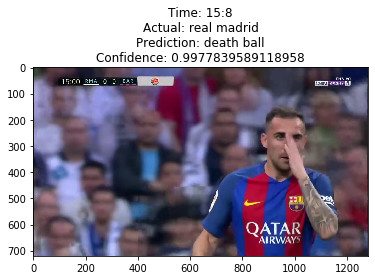

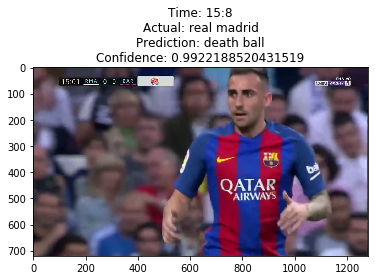

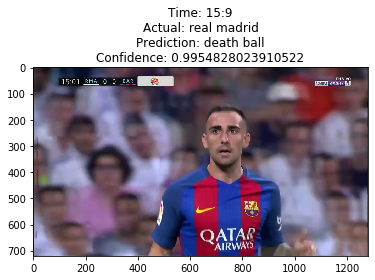

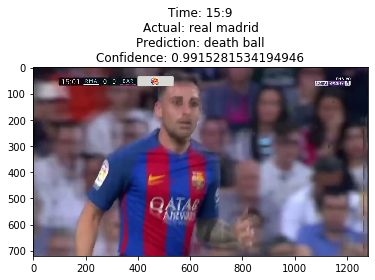

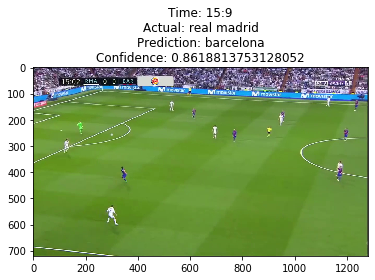

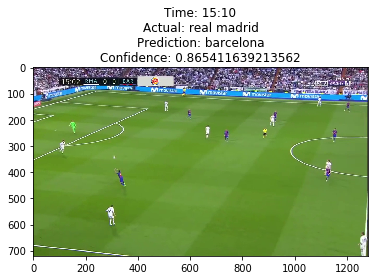

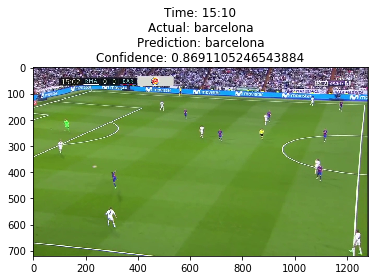

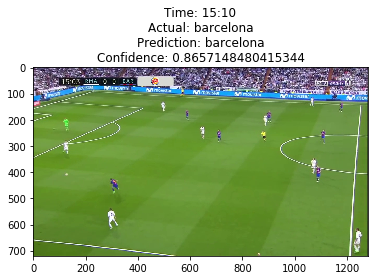

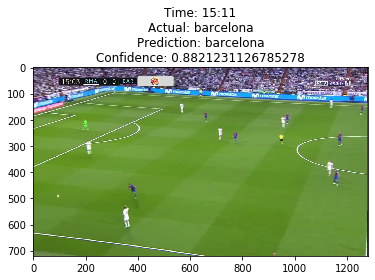

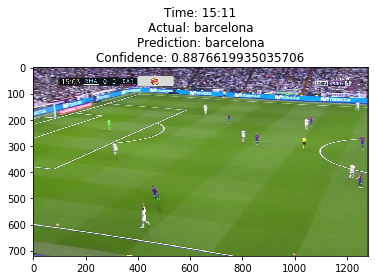

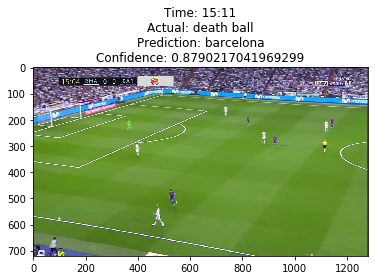

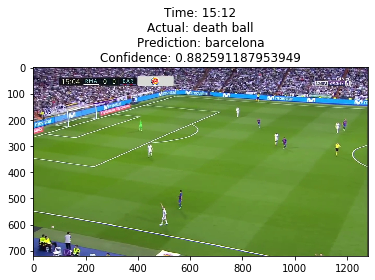

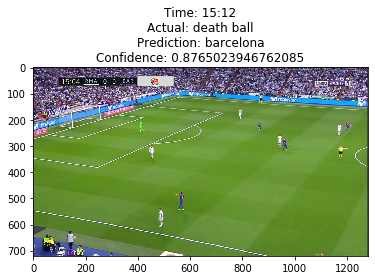

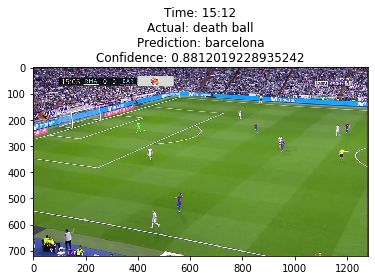

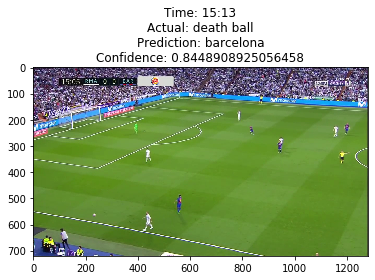

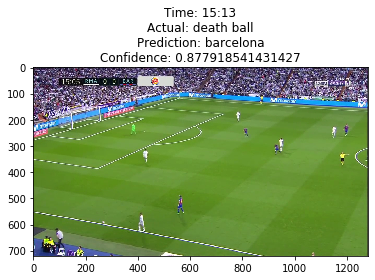

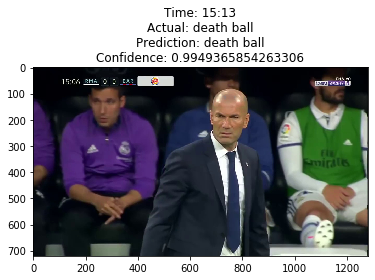

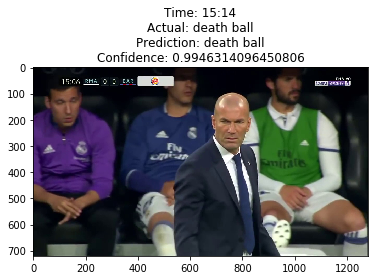

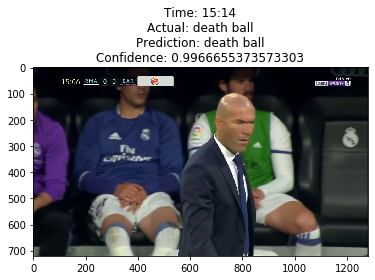

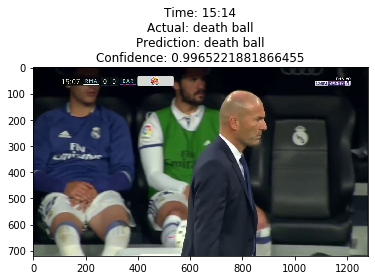

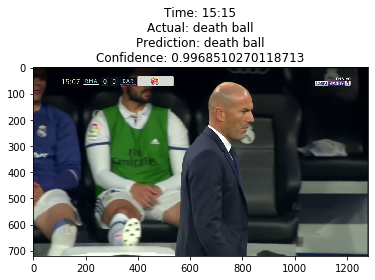

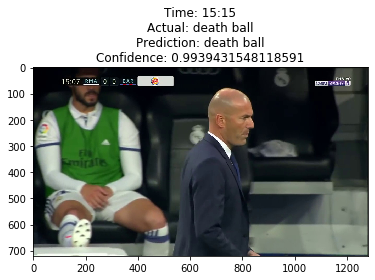

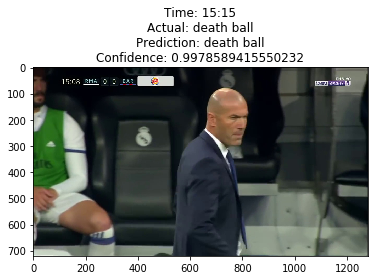

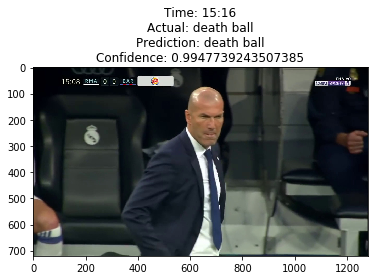

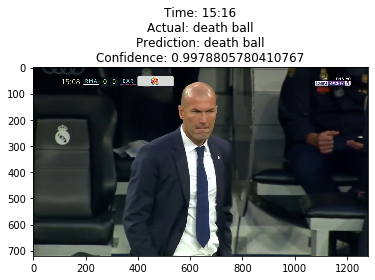

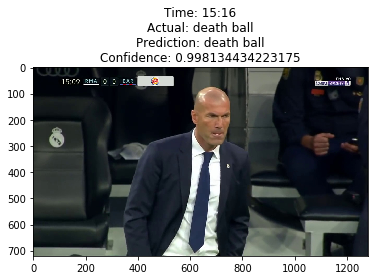

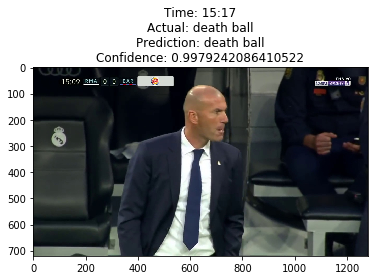

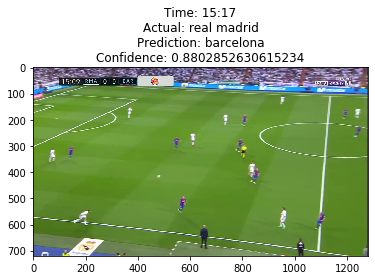

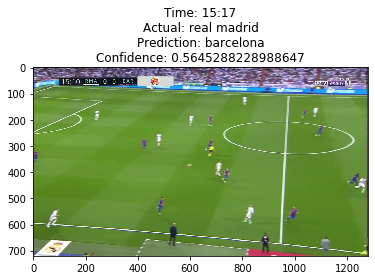

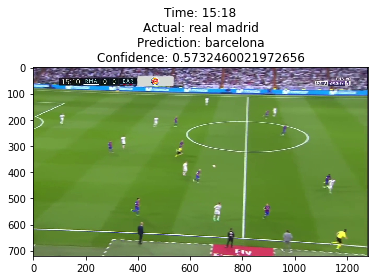

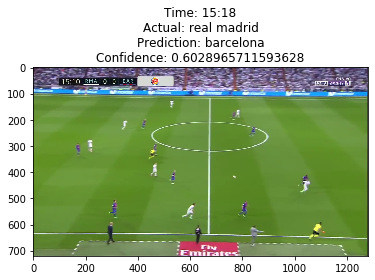

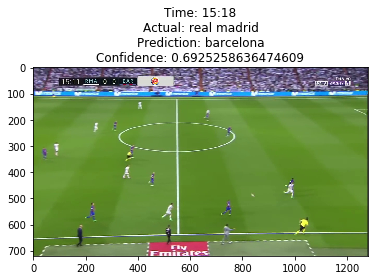

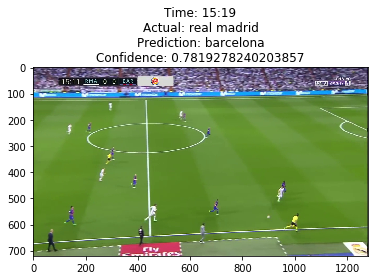

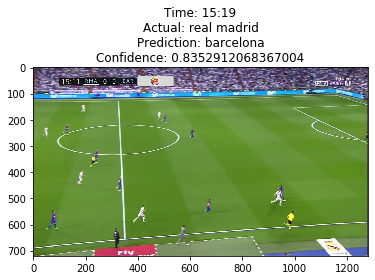

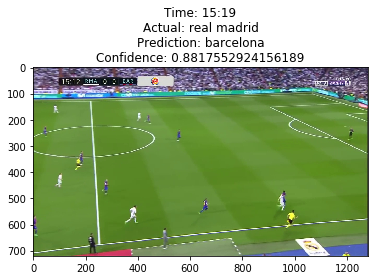

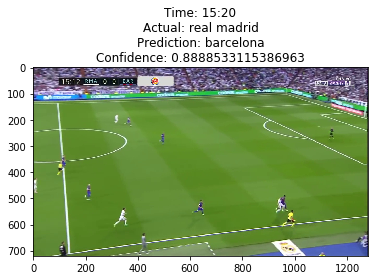

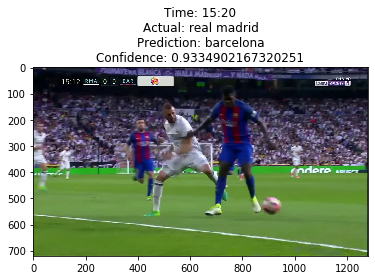

KeyboardInterrupt: ignored

In [54]:
plt.figure(1)
from IPython.display import clear_output

for frame in predictions_cnn.itertuples():
    img = mpimg.imread(frame.img_path)
    plt.clf()
    plt.imshow(img)
    plt.title('Time: ' + str(int(frame.frame/30/60)) + ':' + str(int((frame.frame/30)%60))
              + '\nActual: ' + get_human_label(frame.label) 
              + '\nPrediction: ' + get_human_label(frame.pred_label) 
              + '\nConfidence: ' + str(frame.confidence)
             )
    #clear_output()
    plt.show()
    plt.pause(0.33)

## Save to VM and then Drive

In [0]:
predictions_cnn.to_csv('predictions_cnn.csv', index = False)

In [0]:
!cp predictions_cnn.csv "$drive_root"